### Importing Packages

In [34]:
%pip install scipy
%pip install matplotlib

from scipy.signal import butter, lfilter, freqz

import numpy as np
# Plotting lib
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: C:\Users\elias\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: C:\Users\elias\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# __Case study:__ Morse Code in Analog and Digital signals

In the provided image, you can observe the structural overview of our case study. The analysis of the entire system involves dissecting two key components: the __"Sender"__ and the __"Receiver."__

The process begins with the __"Sender"__ inputting _"Text messages"_ as string data into the __"Text to Morse Encryptor"__. This encryptor transforms the text into a combination of _dots and dashes (Morse Code)_.

Subsequently, the encrypted signal is transmitted to the __"Analog Signal Emulator"__ via a "Communication Protocol" that defines how dots and dashes should be portrayed as _"ON" and "OFF"_ signals, effectively simulating an analog signal. This signal, infused with _Randomized Noise_ from the environment, departs from the __"Sender"__ and is received by the __"Receiver"__.

Upon reaching the __"Receiver"__, the signal undergoes a sequence of transformations. Initially, it traverses a __"Low-Pass Filter"__ to eliminate high-frequency noise. Following this, the signal is sampled by the __"Analog-to-Digital Converter (ADC)"__, marking the transition from _continuous-time_ to _discrete-time_. The sampled signal is then __normalized__ to 1 and 0, preparing it for processing by the __"Signal Decoder"__. The __"Signal Decoder"__, employing the same "Communication Protocol" as the __"Sender"__, decodes the signal back into _dots and dashes (Morse Code)_.

In the final step, the _Morse Code_ is decrypted to reveal the original _"Text message"_, which is then visible to the __"Receiver"__. 

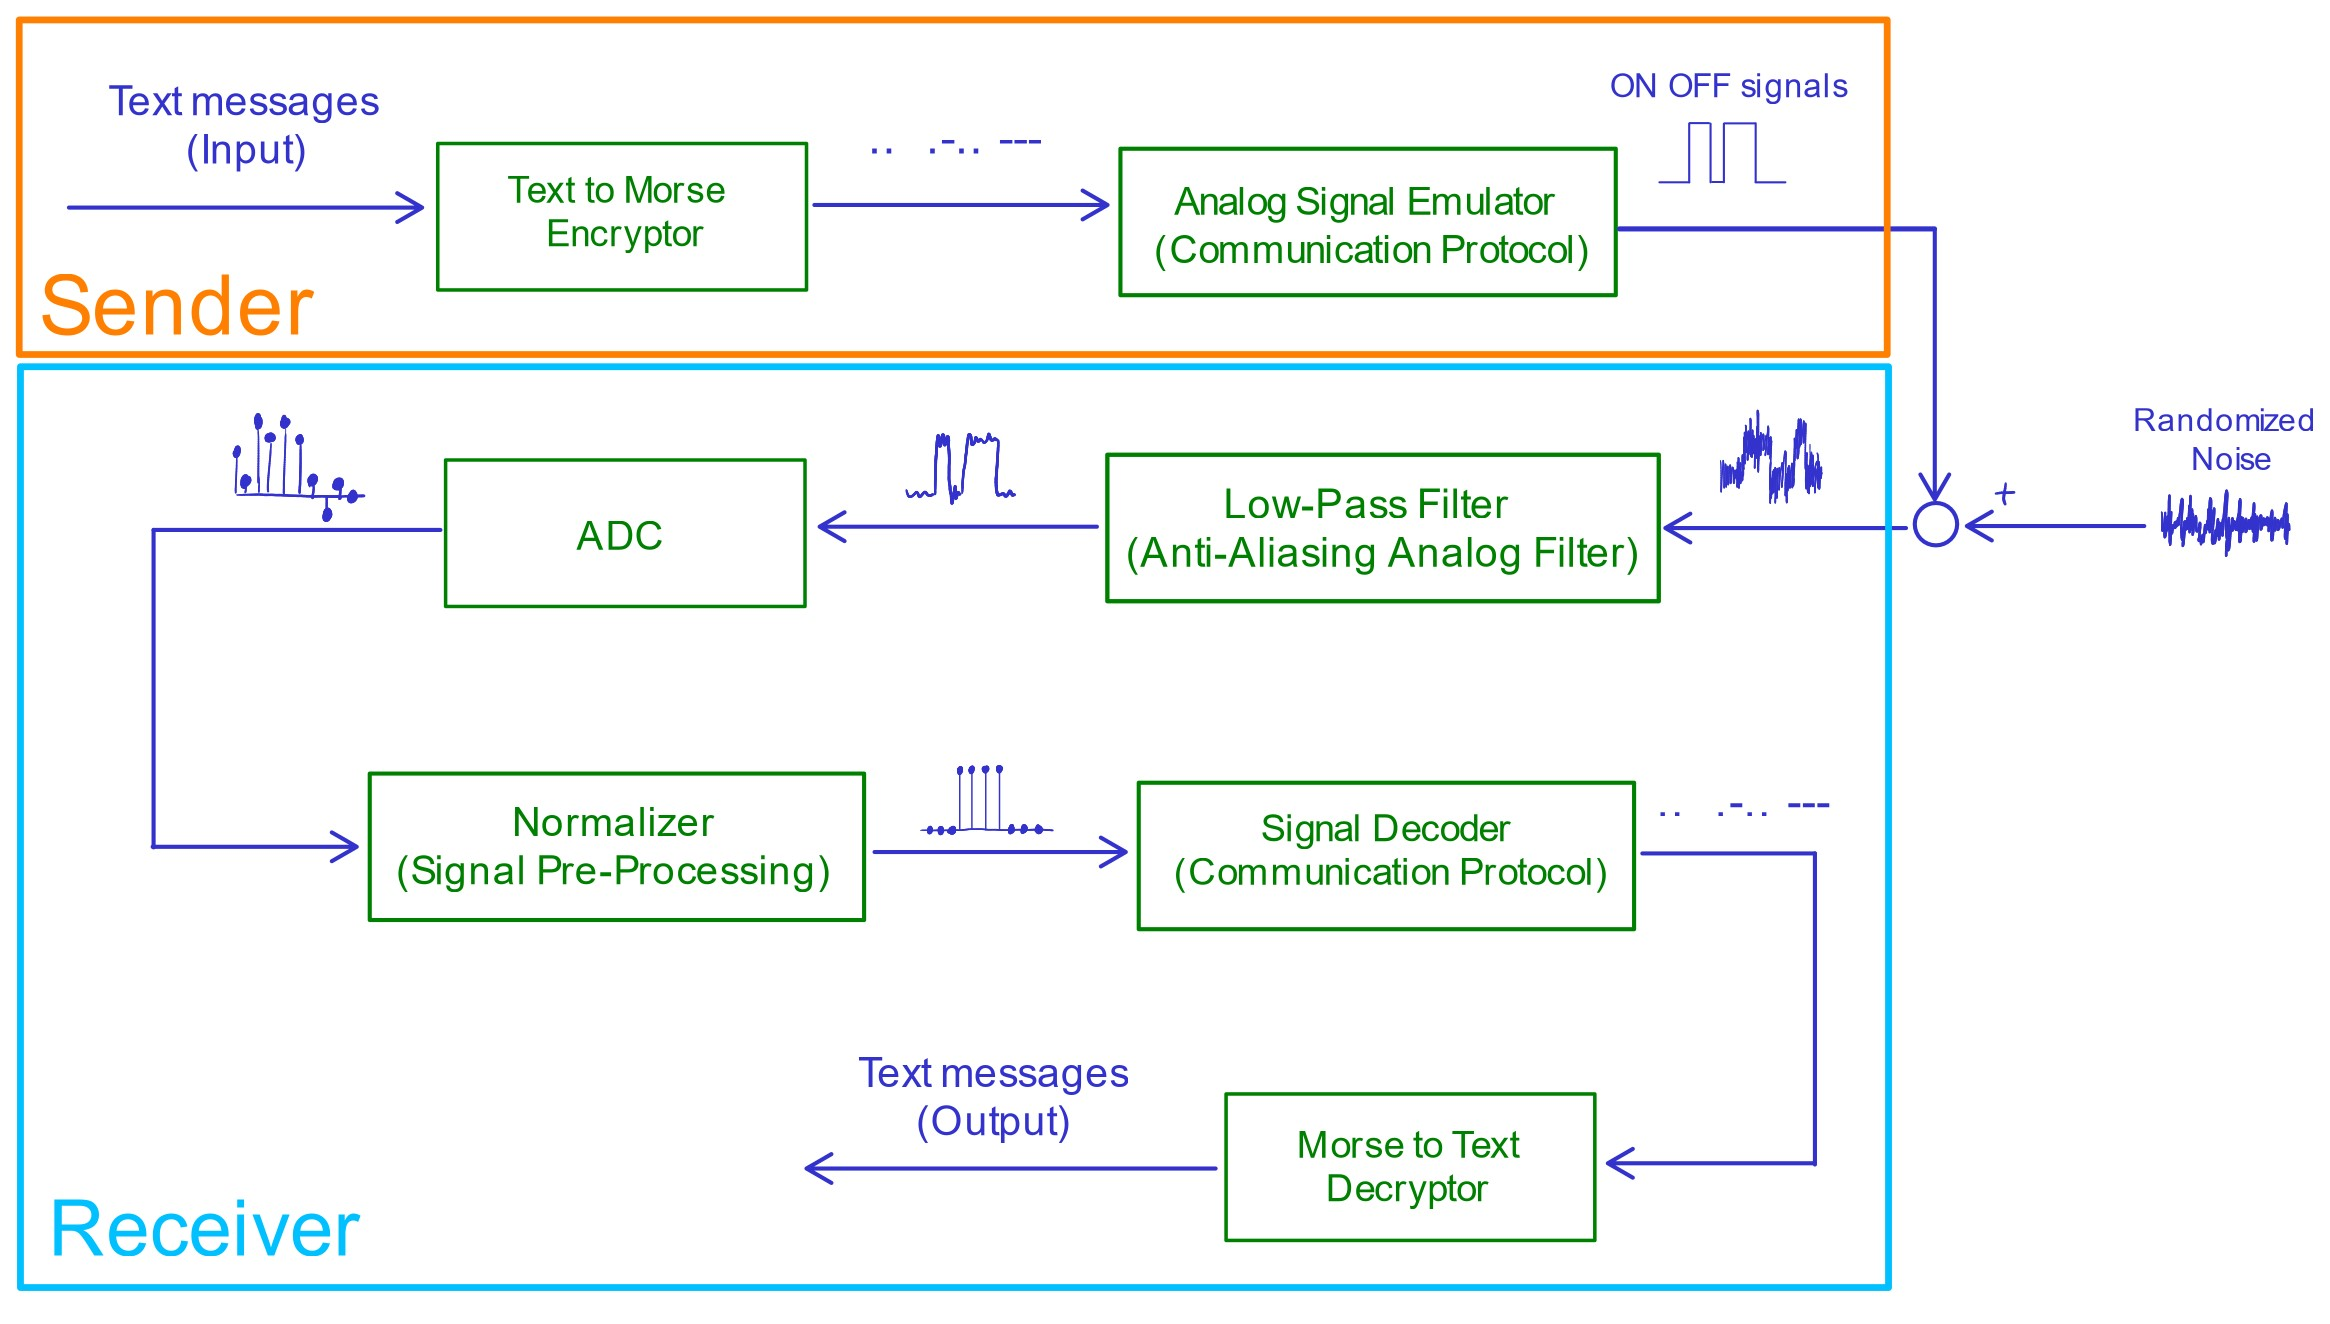

### Necessary Functions for Morse Code and Text Conversion

This Section includes the __"Morse  Encryptor/Decryptor"__ functions, please do not touch it!

#### Morse code dictionary

In [35]:
MORSE_CODE_DICT = { 'A':'.-', 'B':'-...',
                    'C':'-.-.', 'D':'-..', 'E':'.',
                    'F':'..-.', 'G':'--.', 'H':'....',
                    'I':'..', 'J':'.---', 'K':'-.-',
                    'L':'.-..', 'M':'--', 'N':'-.',
                    'O':'---', 'P':'.--.', 'Q':'--.-',
                    'R':'.-.', 'S':'...', 'T':'-',
                    'U':'..-', 'V':'...-', 'W':'.--',
                    'X':'-..-', 'Y':'-.--', 'Z':'--..',
                    '1':'.----', '2':'..---', '3':'...--',
                    '4':'....-', '5':'.....', '6':'-....',
                    '7':'--...', '8':'---..', '9':'----.',
                    '0':'-----', ', ':'--..--', '.':'.-.-.-',
                    '?':'..--..', '/':'-..-.', '-':'-....-',
                    '(':'-.--.', ')':'-.--.-','':''}

#### Text to Morse Encryptor (function)

In [36]:
# Function to encrypt the string
# According to the Morse code chart
def encrypt(message):
    cipher = ''
    for letter in message:
        if letter != ' ':

            # Looks up the dictionary and adds the
            # corresponding Morse code
            # along with a space to separate
            # Morse codes for different characters
            cipher += MORSE_CODE_DICT[letter] + ' '
        else:
            # 1 space indicates different characters
            # and 2 indicate different words
            cipher += ' '

    return cipher

#### Morse to Text Decryptor (function)

In [37]:
# Function to decrypt the string
# from Morse to English
def decrypt(message):
 
    # Extra space added at the end to access the
    # last morse code
    message += ' '
 
    decipher = ''
    citext = ''
    for letter in message:
 
        # checks for space
        if (letter != ' '):
 
            # counter to keep track of space
            i = 0
 
            # storing Morse code of a single character
            citext += letter
 
        # In the case of space
        else:
            # If i = 1 that indicates a new character
            i += 1
 
            # If i = 2 that indicates a new word
            if i == 2 :
 
                 # Adding space to separate words
                decipher += ' '
            else:
                try:
 
                    # accessing the keys using their values (reverse of encryption)
                    decipher += list(MORSE_CODE_DICT.keys())[list(MORSE_CODE_DICT
                    .values()).index(citext)]
                    citext = ''
                except:
                    pass
 
    return decipher

## __Signal Sender__

In this section, we simulate a message sender. Before everything, we need to define a __Communication(COM) Protocol__

### _Communication Protocol_

The __"Morse Communication(COM) Frequency"__ sets the minimum duration for the "ON" signal when simulating the analog signal. In simpler terms, it dictates the operational frequency of the __"Analog Signal Emulator"__ and, consequently, establishes the data transfer rate.

In [38]:
# You can define these values.
# Morse communication Frequency in [Hz]
MORSE_COM_FREQ = 5

Then we define a standardized "ON" & "OFF" analog signal to represent the _Morse Code_


- ".": 1 Interval "ON" followed by 1 Interval "OFF"
- "-": 2 Interval "ON" followed by 1 Interval "OFF"
- " ": 2 Interval "OFF"


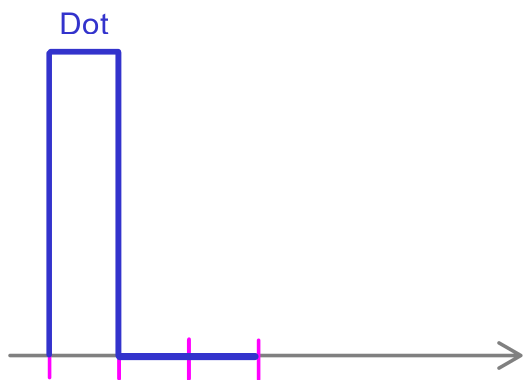
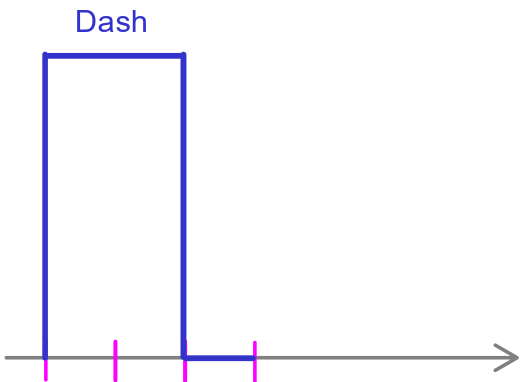
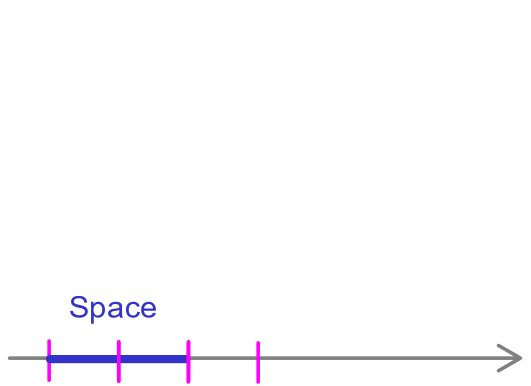


It's worth noting that we intentionally avoid using 3 Interval "OFF" as a "Space." 

If there's no "Space" in the code, the maximum number of Interval "OFF" followed by each other will be 2.

When a "Space" follows a ".", or "-", the minimum number of Interval "OFF" becomes 3. This adjustment shortens the signal for a "Space", therefore slightly increasing the data transfer rate compared with using 3 Interval "OFF" for a "Space". 

TO DO-------------------------------------------------------------

In [39]:
"""
Standardized signal to represent the Morse Signal:

".": 1 ON & 1 OFF
"-": 2 ON & 1 OFF
" ": 2 OFF

Below you see the Function that turns these into ON and OFF signals.
"""

def code_to_signal(t_cont: np.array,                
                   morse_code,
                   morse_com_freq):
  
  # A calculation turns the frequency to the period in [s]
  # The period defines how long a "." is (represented in signal as on)
  period = 1/morse_com_freq
  
  # Generate an empty array matching the size of the continuous time array
  # for signal data storage
  morse_signal = np.zeros(t_cont.size)

  e = 0
  i = 0

  # Check if counter within both array
  while ((e < len(morse_code)) and (i < t_cont.size - 1)):
    # If yes, read the current character in Morse code and 
    # determine what to write on the signal data storage
    
    """
    ".": 1 ON & 1 OFF
    "-": 2 ON & 1 OFF
    " ": 2 OFF
    """
    
    if morse_code[e] == '.':

      on_end = t_cont[i] + period
      off_end = t_cont[i] + 2*period

    if morse_code[e] == "-":
      on_end = t_cont[i] + 2*period
      off_end = t_cont[i] + 3*period

    if morse_code[e] == " ":
      on_end = t_cont[i]
      off_end = t_cont[i] + 2*period

    # After determining how long and what to write, write the signal on the data array
    while ((t_cont[i] < on_end) and (i < t_cont.size - 1)):
      # Write the ON state
      morse_signal[i] = 1
      i = i + 1

    while ((t_cont[i] <= off_end) and (i < t_cont.size - 1)):
      # Write the OFF state
      morse_signal[i] = 0
      i = i + 1

    e = e + 1
    
  return morse_signal



def signal_to_code(t_dis: np.array,
                   dis_morse_signal: np.array,
                   morse_com_freq):
  
  # A calculation turns the frequency to the period in [s]
  # The period defines how long a "." is (represented in signal as on)
  period = 1/morse_com_freq
  
  i = 0
  p = 0
  state = 0
  hold_time = 0
  code = ""
  
  while i < len(t_dis)-1:
    
    while state == 0:
      # Check if the element index is still in the range of the data array.
      # Check if the state remains unchanged, hence signal is smaller than 0.8.
      # Check if the OFF is being held for too long, might mean that the message has ended.
      while i < len(t_dis)-1 and dis_morse_signal[i] < 0.8 and hold_time < 20*period:
        # Move to the next element.
        i += 1
        hold_time = t_dis[i] - t_dis[p]
        
      if i >= len(t_dis)-1:
        # This condition indicates the index is over the total elements
        # The function should be terminated!
        return code
      
      if hold_time >= 10*period:
        # This condition indicates the message ends.
        code += "  "
        return code
      
      # Otherwise it indicates a state change from OFF to ON, and the message continues.
      if hold_time >= 0.8*period:
        if hold_time >= 2.8*period:
          if hold_time >= 4.8*period:
            code += "  "
          else:
            code += " "
      # Otherwise it was just a break to start another character.
      
      # Change the state to ON
      state = 1
      # Refresh the timer
      p = i
      
    while state == 1:
      # Check if the element index is still in the range of the data array.
      # Check if the state remains unchanged, hence signal is higher than 0.8.
      # Check if the ON is being held for too long, might mean that the message has an error.
      while i < len(t_dis)-1 and dis_morse_signal[i] >= 0.8 and hold_time < 20*period:
        # Move to the next element.
        i += 1
        hold_time = t_dis[i] - t_dis[p]
      
      if i >= len(t_dis)-1:
        # This condition indicates the index is over the total elements
        # The function should be terminated!
        return code
      
      if hold_time >= 20*period:
        # This condition indicates the message ends.
        code += "  "
        return code
      
      # Otherwise it indicates a state change from ON to OFF, and the message continues.
      if hold_time >= 0.8*period:
        # If ON time is longer than 1.8, it's a "-"
        if hold_time >= 1.8*period:
          code += "-"
        else:
          code += "."
      
      # Change the state to OFF
      state = 0
      # Refresh the timer
      p = i
    
  return code
  

In [40]:
""" 
We need a continuous time array for us to keep track of the continuous analog signals.
But in the computational world, there's no true continuous time domain.
Everything is eventually in discrete time.

So here we create an array for continuous time, 
this array will be very big and the time steps between each value will be so small,
smaller than our Morse communication period, so it can be seen as "continues"
"""

# Do not change the code below if you don't know what you are doing!
# Plotting START & END time in [s]
T_CONT_START = 0
T_CONT_END = 15


# Continues Time domain plotting Data storage Frequency in [Hz]
T_CONT_FREQ = 200
# A calculation turns the frequency to the period in [s]
T_COUNT_PERIOD = 1/T_CONT_FREQ


# Get the total time
Time_span = T_CONT_END - T_CONT_START
# Calculate how many elements should be in the Continues Time plotting Data Array
# And force it to be int.
t_steps = int (Time_span*T_CONT_FREQ)


# Generate an Array for continuous time
T_CONT = np.linspace(T_CONT_START,T_CONT_END,t_steps + 1)

### Text Message (Input) (type your message in the code)

In [41]:
# Message to send
MESSAGE = "I love CS 2"


# Morse Code Encryption
Morse_code_To_Send = encrypt(MESSAGE.upper())
print(Morse_code_To_Send)

..  .-.. --- ...- .  -.-. ...  ..--- 


### Morse Code to Analog Signal

..  .-.. --- ...- .  -.-. ...  ..--- 


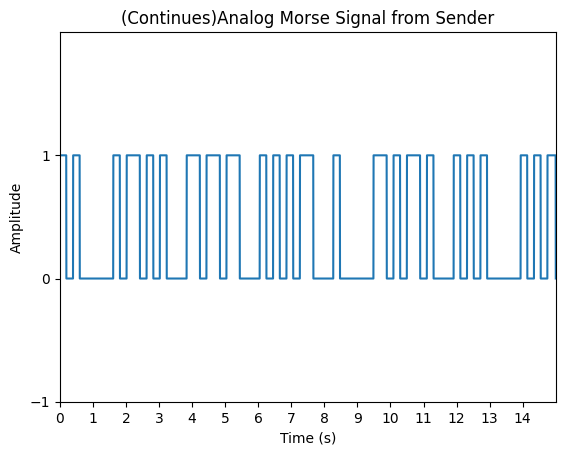

In [42]:
# We defined the code to signal function above in the communication protocol section.
CONT_Morse_Signal_Send = code_to_signal(T_CONT,Morse_code_To_Send,MORSE_COM_FREQ)


print(Morse_code_To_Send)


# Plot out the continuous signal
fig, ax = plt.subplots()
ax.plot(T_CONT,CONT_Morse_Signal_Send)
ax.set_title("(Continues)Analog Morse Signal from Sender")
ax.set(xlim=(T_CONT_START,T_CONT_END),
       xticks=np.arange(T_CONT_START, T_CONT_END),
       ylim=(-0.5, 2),
       yticks=np.arange(-1, 2))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

".": 1 Period ON & 1 OFF


"-": 2 ON & 1 OFF


" ": 2 OFF

## Transmission and introduce noise

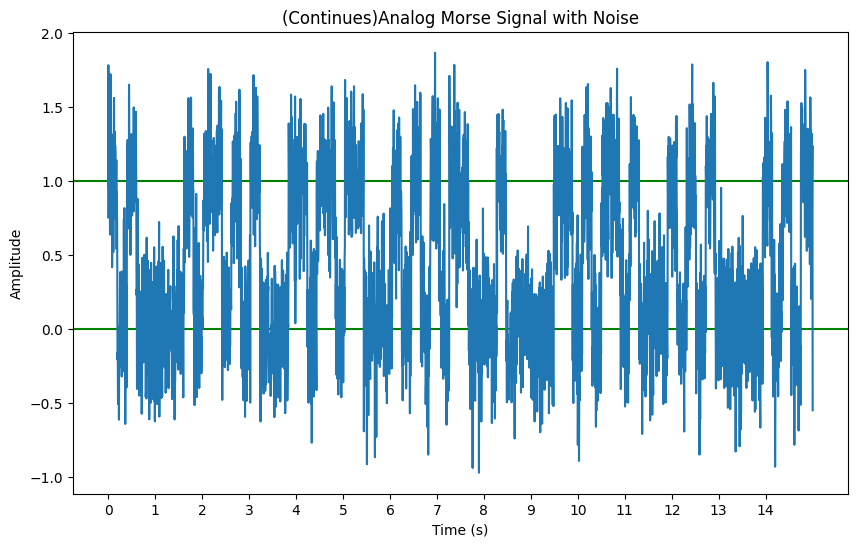

In [43]:
CONT_Morse_Signal_w_noise = CONT_Morse_Signal_Send + 0.3 * np.random.normal(size=len(T_CONT))

# Plot out the continuous signal with noise introduced

plt.figure(figsize=(10, 6))
plt.title("(Continues)Analog Morse Signal with Noise")
plt.axhline(y=1, color='g', linestyle='-')
plt.axhline(y=0, color='g', linestyle='-')
plt.plot(T_CONT, CONT_Morse_Signal_w_noise)
plt.xticks(np.arange(T_CONT_START, T_CONT_END))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

## Signal Receiver

### Low Pass Filter (anti-aliasing analog filter)

Here we define a low-pass filter and try to filter out some high-frequency random noise mixed in the signal before we sample it.

Here we used a scipy package filter named "butter"

In [44]:
# Function to apply a low-pass Butterworth filter
def butter_lowpass_filter(data, cutoff_frequency, sampling_frequency, order=4):
    nyquist = 0.5 * sampling_frequency
    normal_cutoff = cutoff_frequency / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    #print("This is b:")
    #print(b , '\n')
    #print("This is a:")
    #print(a)
    y = lfilter(b, a, data)
    return y

# Set the cutoff frequency for the low-pass filter
CUTOFF_FREQ = 10  # Adjust this based on your requirements

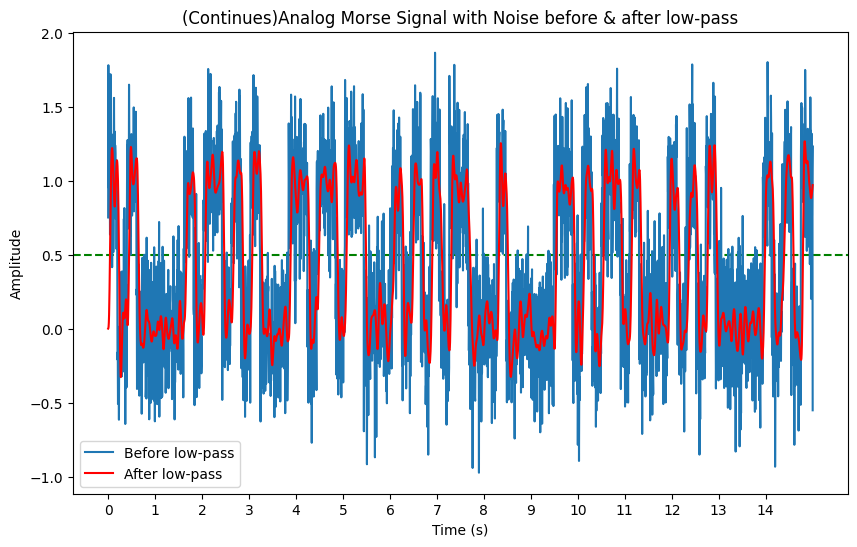

In [45]:
# Apply the low-pass filter
after_low_pass = butter_lowpass_filter(CONT_Morse_Signal_w_noise, CUTOFF_FREQ, T_CONT_FREQ)

# Plot out the continuous signal with noise introduced
# and compare it with the signal that is after low-pass filter

plt.figure(figsize=(10, 6))
plt.axhline(y=0.5, color='g', linestyle='--')
plt.title("(Continues)Analog Morse Signal with Noise before & after low-pass")
plt.plot(T_CONT, CONT_Morse_Signal_w_noise, label='Before low-pass')
plt.plot(T_CONT, after_low_pass, 'r' ,label='After low-pass')
plt.xticks(np.arange(T_CONT_START, T_CONT_END))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

### Signal Sensor (ADC)

This Section define our ADC function.

In [46]:
# Define the sampling frequency of your Receiver (Analog to Digital converter) in [Hz]
SAMPLING_FREQ = 50



def analog_digital_converter(t_cont: np.array,
                             cont_signal: np.array,
                             freq,
                             t_or_s):
    # Converting the Sampling frequency to the sampling period.
    period = 1/freq
 
    # Initialize an empty array to store the time data for discrete time.
    t_dis = np.zeros(t_cont.size)
    dis_signal = np.zeros(t_cont.size)
 
    i = 0
    p = 0
    e = 0
 
    # Check if the element index is still in the range of the time array.
    while i < len(t_cont)-1:
        
        # Collect data from continuous time and write it to the sensor data array.
        t_dis[e] = t_cont[i]
        dis_signal[e] = cont_signal[i]
        
        # Move to the next element in the sensor data.
        e += 1
        
        # Keep skipping the time till the next time to be sampled by the sensor.
        # While checking if the element is still in range.
        while (t_cont[i] < t_cont[p] + period) and (i < len(t_cont)-1):
            i += 1
        # We skipped a period in continuous time, now it is time to collect data.
        p = i
    
    # If dis_time wanted, return dis_time array.
    if t_or_s == "t":
        return t_dis   
    
    # If dis_signal wanted, return dis_signal array
    if t_or_s == "s":
        return dis_signal
 
    return None

    

### Received raw data from Signal Sensor

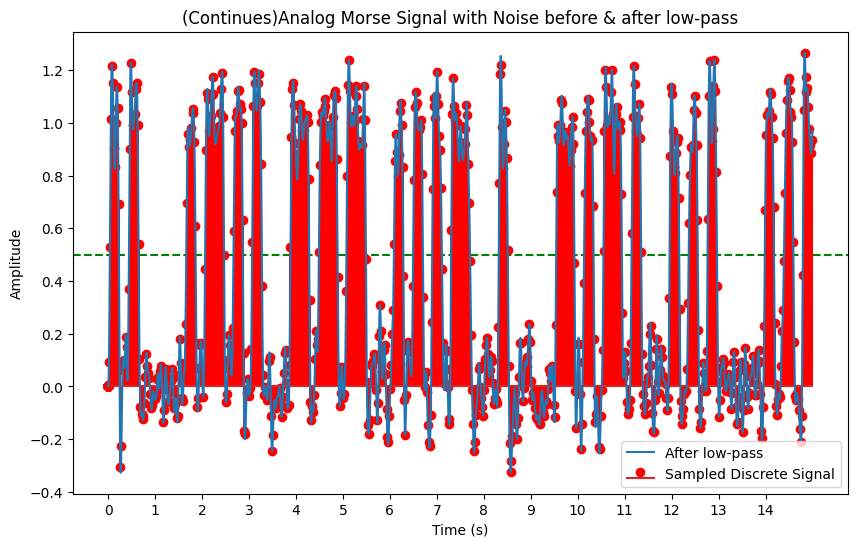

In [47]:
T_DIS_Morse = analog_digital_converter(T_CONT,
                                       after_low_pass,
                                       SAMPLING_FREQ,
                                       "t")

DIS_Morse_Signal_w_N_Raw = analog_digital_converter(T_CONT,
                                                    after_low_pass,
                                                    SAMPLING_FREQ,
                                                    "s")

# Plot out the continuous signal with noise introduced

plt.figure(figsize=(10, 6))
plt.axhline(y=0.5, color='g', linestyle='--')
plt.title("(Continues)Analog Morse Signal with Noise before & after low-pass")
plt.stem(T_DIS_Morse, DIS_Morse_Signal_w_N_Raw, 'r' ,label='Sampled Discrete Signal')
plt.plot(T_CONT, after_low_pass, label='After low-pass')
plt.xticks(np.arange(T_CONT_START, T_CONT_END))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

### Sensor Raw data post processing

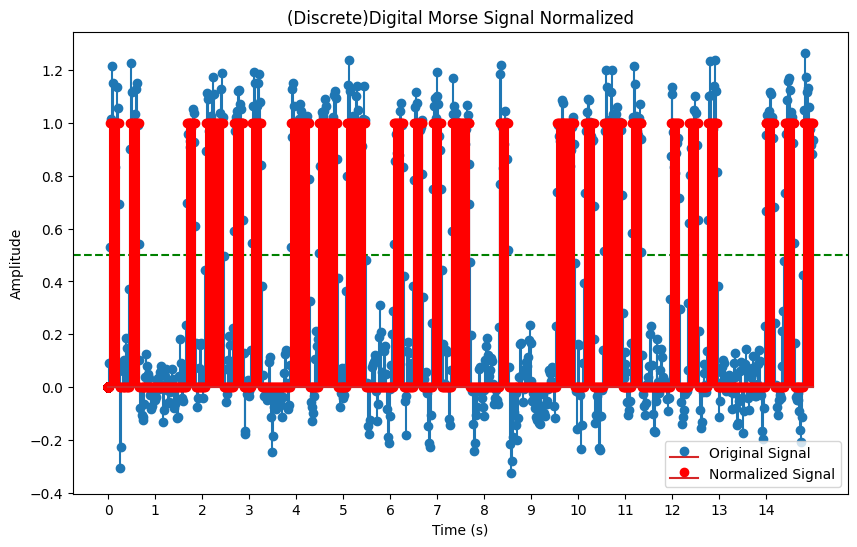

In [48]:
"""""
# inputs: 
    raw sensor data as np.array; 
    minimum threshold; 
    normalize value after threshold;
    idle value when data is lower than the threshold
# output: 
    filtered data as np.array with the same size as input raw data np.array.
# TASK: 
    Do a simple normalization for the input data.
    If the signal value is lower than the threshold, set the value to idle value.
    If the signal value is higher than the threshold, set the value to the normalized value
"""
def data_normalization_sol(data_raw: np.array,
                                  min: float,
                                  normalization: float,
                                  idle: float):
    
    # Create an array to save the filtered data with the same size as the raw data array
    data_norm = np.zeros(data_raw.size)
    
    # check for each value and normalize or set it to idle value in the filtered data array
    for i in range(data_raw.size - 1):
        if min <= data_raw[i]:
            data_norm[i] = normalization
        else:
            data_norm[i] = idle
        i += 1 
    return data_norm


DIS_Morse_Signal_w_N_Normalized = data_normalization_sol(DIS_Morse_Signal_w_N_Raw,0.5,1,0)



plt.figure(figsize=(10, 6))
plt.axhline(y=0.5, color='g', linestyle='--')
plt.title("(Discrete)Digital Morse Signal Normalized")
plt.stem(T_DIS_Morse, DIS_Morse_Signal_w_N_Raw, label='Original Signal')
plt.stem(T_DIS_Morse, DIS_Morse_Signal_w_N_Normalized, 'r' ,label='Normalized Signal')
plt.xticks(np.arange(T_CONT_START, T_CONT_END))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

### Data decoding with COM Protocol

In [49]:
CODE_Received_I = signal_to_code(T_DIS_Morse,DIS_Morse_Signal_w_N_Normalized,MORSE_COM_FREQ)
CODE_Received_II = signal_to_code(T_DIS_Morse,DIS_Morse_Signal_w_N_Raw,MORSE_COM_FREQ)

print("Code sent:")
print(Morse_code_To_Send)
print("Received signal filtered decrypted to Code:")
print(CODE_Received_I)
print("Code to message:")
print(decrypt(CODE_Received_I))
print("Received signal without normalization decrypted to Code:")
print(CODE_Received_II)


"""""
The following line sometimes can cause problems.
Uncomment it to see the result when signals are not normalized and 
directly feed into the decryption
"""
#print("Code to message:")
#print(decrypt(CODE_Received_II))

Code sent:
..  .-.. --- ...- .  -.-. ...  ..--- 
Received signal filtered decrypted to Code:
..  .-.. --- ...- .  -.-. ...  ..
Code to message:
I LOVE CS I
Received signal without normalization decrypted to Code:
..  .-.. .-- ..- .  .... ...  ..


'""\nThe following line sometimes can cause problems.\nUncomment it to see the result when signals are not normalized and \ndirectly feed into the decryption\n'

# Exercise

## Nyquist Frequency

Validation of the Nyquist Frequency and finding the minimum Sampling frequency that guarantees a correct message decryption.

In [50]:
# You can define these values and play around with them.

# Morse communication Frequency in [Hz] 
# default (5)
Ex_MORSE_COM_FREQ = 5


# Nyquist Frequency in [Hz] 
# default (10)
# Calculate using the Morse communication Frequency
Ex_MORSE_COM_NyFREQ = 10


# Message to send 
# default ("I CAN DO CS II")
Ex_MESSAGE = "I CAN DO CS II"


# ADC Sampling Frequency in [Hz]
# default (20)
Ex_SAMPLING_FREQ = 20

#### Perfect condition

Which minimum sampling frequency do you observe? When there's no noise in the received signal?

In [51]:
# Generate the Morse Signal in continues-time (CONT)
Ex_CONT_Morse_Signal_Send = code_to_signal(T_CONT, encrypt(Ex_MESSAGE), Ex_MORSE_COM_FREQ)


# Sampled by ADC
# Generate Time Data
Ex_T_DIS_Morse = analog_digital_converter(T_CONT,
                                          Ex_CONT_Morse_Signal_Send,
                                          Ex_SAMPLING_FREQ,
                                          "t")
# Sample the Signal
Ex_DIS_Morse_Signal_Raw = analog_digital_converter(T_CONT,
                                                   Ex_CONT_Morse_Signal_Send,
                                                   Ex_SAMPLING_FREQ,
                                                   "s")


# Decode signal to Morse
Ex_CODE_Received = signal_to_code(Ex_T_DIS_Morse,
                                  Ex_DIS_Morse_Signal_Raw,
                                  Ex_MORSE_COM_FREQ)


# Decrypt Morse to message.
print("Message received:")
print(decrypt(Ex_CODE_Received))

Message received:
I CAN DO CI


#### Noise Condition (Exercise in this Section)

Now we introduce a random noise to the signal.

##### Without any post-processing

In [52]:
# Generate the Morse Signal in continues-time (CONT) with random noise
Ex_CONT_Morse_Signal_w_noise = code_to_signal(T_CONT,
                                              encrypt(Ex_MESSAGE),
                                              Ex_MORSE_COM_FREQ)+ 0.2 * np.random.normal(size=len(T_CONT))


# Feed through anti-aliasing(low-pass) filter before feed into ADC
Ex_CONT_Morse_Signal_w_noise_af_low_pass = butter_lowpass_filter(Ex_CONT_Morse_Signal_w_noise,
                                                                 Ex_MORSE_COM_NyFREQ,
                                                                 T_CONT_FREQ)


# Sampled by ADC
# Generate Time Data
Ex_T_DIS_Morse = analog_digital_converter(T_CONT,
                                          Ex_CONT_Morse_Signal_w_noise_af_low_pass,
                                          Ex_SAMPLING_FREQ,
                                          "t")

# Sample the Signal
Ex_DIS_Morse_Signal_Raw = analog_digital_converter(T_CONT,
                                                   Ex_CONT_Morse_Signal_w_noise_af_low_pass,
                                                   Ex_SAMPLING_FREQ,
                                                   "s")


# Decode signal to Morse
Ex_CODE_Received = signal_to_code(Ex_T_DIS_Morse,
                                  Ex_DIS_Morse_Signal_Raw,
                                  Ex_MORSE_COM_FREQ)


# Decrypt Morse to message. (Without Post-Processing)

"""""
Noticed:
The following lines can cause problems due to noise feeding into the decryption.
Decrypt Morse to message. (Without Post-Processing) under huge noise conditions
is impossible.
Therefore, the following lines are commented.

Instead, we compare the Morse code between sent and received.
"""

#print("Message received:")
#print(decrypt(Ex_CODE_Received))

print("Code sent:")
print(encrypt(Ex_MESSAGE))

print("Code received:")
print(Ex_CODE_Received)


Code sent:
..  -.-. .- -.  -.. ---  -.-. ...  .. .. 
Code received:
  --. .- .  -.. ---  -.-. ..


We observe that as soon as there's a noise in the signal, our decryption struggles to get the correct message.
Here we see the importance of a filter and signal normalization for post-computation (decryption). 

##### Your code here (Exercise)

Now implement a function to normalize the data.


If you need help, feel free to look at the function above. in the section: Sensor Raw Data post-processing.

In [53]:
"""""
# inputs: 
    raw sensor data as np.array; 
    minimum threshold; 
    normalize value after threshold;
    idle value when data is lower than the threshold
# output: 
    filtered data as np.array with the same size as input raw data np.array.
# TASK: 
    Do a simple normalization for the input data.
    If the signal value is lower than the threshold, set the value to idle value.
    If the signal value is higher than the threshold, set the value to the normalized value
"""
def ex_data_normalization(data_raw: np.array,
                                  min: float,
                                  normalization: float,
                                  idle: float):
    
    # Create an array to save the filtered data with the same size as the raw data array
    data_norm = np.zeros(data_raw.size)
    
    # check for each value and normalize or set it to idle value in the filtered data array
    # Your Code here ---------------------------------------------------------------------------
    
    
    
    return data_norm

# Your Code here -------------------------------------------------------------------------------

##### With post-processing (Code Modification needed)

The first function is the solution.
"Ex_DIS_Morse_Signal_Normalized = data_normalization_sol(Ex_DIS_Morse_Signal_Raw,0.5,1,0)"


You need to implement your function below in able to see your test result.

In [54]:
# Run the Normalized function
# Fine-tune the threshold to make sure a correct Message decryption.
Ex_DIS_Morse_Signal_Normalized = data_normalization_sol(Ex_DIS_Morse_Signal_Raw,0.5,1,0)




# Uncomment the line below and implement your function. 
# Your Code here-----------------------------------------------------------------------------------

#Ex_DIS_Morse_Signal_Normalized = ex_data_normalization()



# Your Code here-----------------------------------------------------------------------------------


# Decode signal to Morse
Ex_CODE_Received = signal_to_code(Ex_T_DIS_Morse,
                                  Ex_DIS_Morse_Signal_Normalized,
                                  Ex_MORSE_COM_FREQ)


# Decrypt Morse to message.
print("Message received:")
print(decrypt(Ex_CODE_Received))

Message received:
I CAN DO CI


## Data transfer rate

We noticed that in the Nyquist Frequency section, using default values:


Morse communication Frequency: 5 [Hz]


Nyquist Frequency: 10 [Hz]


Message to send: "I CAN DO CS II"


ADC Sampling Frequency 20 [Hz]


We can not send the full message.


Think about how can you increase the data transfer rate.

### Increase operating and sampling Frequency (Exercise in this Section)

#### Adjust the Morse-COM frequency and define a message to send

Adjust the Morse-communication protocol frequency (Ex_MORSE_COM_FREQ) to a higher value. You can imagine that: instead of speaking a sentence slowly, now we speak it fast so we can finish speaking the whole sentence in a shorter time. Thus in the same given time as before, we can pass on more information.

In [55]:
# You can define these values and play around with them.

# Morse communication Frequency in [Hz]
# Before (5)
# default (20)
Ex_MORSE_COM_FREQ = 20


# Nyquist Frequency in [Hz]
# Calculated manually using the Morse communication Frequency
# Before (5)
# default (40)
Ex_MORSE_COM_NyFREQ = 40


# Message to send
Ex_MESSAGE = "I CAN DO CS II and beyond"


# ADC Sampling Frequency in [Hz]
# Before (20)
# default (200)
Ex_SAMPLING_FREQ = 200

#### Simulation Run & Results (Exercise in this Section)

Now we run through the steps.


Generate an analog signal with (code_to_signal).


And use our predefined ADC (analog_digital_converter) to sample the signal.


Decode that sampled signal to Morse code (signal_to_code).


And finally, decrypt the Code to the Message (decrypt(...)).

In [56]:
# Generate the Morse Signal in continues-time (CONT)
Ex_CONT_Morse_Signal_Send = code_to_signal(T_CONT, encrypt(Ex_MESSAGE.upper()), Ex_MORSE_COM_FREQ)

# Apply the low-pass filter
#after_low_pass = butter_lowpass_filter(Ex_CONT_Morse_Signal_Send, Ex_MORSE_COM_NyFREQ, T_CONT_FREQ)


# Sampled by ADC
# Generate Time Data
Ex_T_DIS_Morse = analog_digital_converter(T_CONT,
                                          Ex_CONT_Morse_Signal_Send,
                                          Ex_SAMPLING_FREQ,
                                          "t")
# Sample the Signal
Ex_DIS_Morse_Signal_Raw = analog_digital_converter(T_CONT,
                                                   Ex_CONT_Morse_Signal_Send,
                                                   Ex_SAMPLING_FREQ,
                                                   "s")


# Decode signal to Morse
Ex_CODE_Received = signal_to_code(Ex_T_DIS_Morse,
                                  Ex_DIS_Morse_Signal_Raw,
                                  Ex_MORSE_COM_FREQ)


# Decrypt Morse to message.
print(encrypt(Ex_MESSAGE.upper()))
print("Message received:")
print(Ex_CODE_Received)
print(decrypt(Ex_CODE_Received))


..  -.-. .- -.  -.. ---  -.-. ...  .. ..  .- -. -..  -... . -.-- --- -. -.. 
Message received:
..  -.-. .- -.  -.. ---  -.-. ...  .. ..  .- -. -..  -... . -.-- --- -. -..  
I CAN DO CS II AND BEYOND 


Now compare with the result before in part "Nyquist Frequency". There we receive a sentence of "I CAN DO C" in 15 [s]. While here, after we increase the Morse-COM protocol frequency, we can receive a full sentence of "I CAN DO CS II AND BEYOND" in the same 15 [s].

##### Your code here (Exercise)

Study the plotting function we used before, explore the possibility of the "matplotlib" package (https://matplotlib.org/)

And plot out the result signals nicely.

In [57]:
# Your code here---------------------------------------------------------------------------------



# Your code here---------------------------------------------------------------------------------

###### Solution

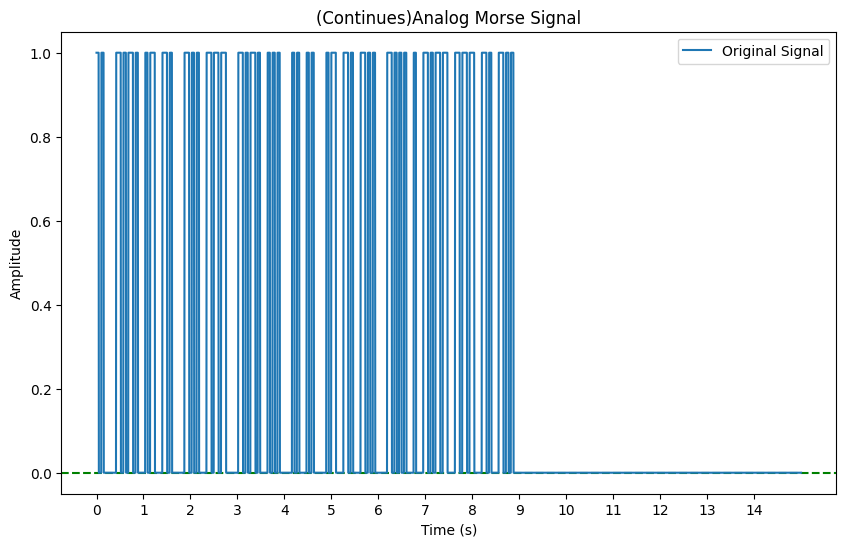

In [58]:
plt.figure(figsize=(10, 6))
plt.axhline(y=0, color='g', linestyle='--')
plt.title("(Continues)Analog Morse Signal")
plt.plot(T_CONT, Ex_CONT_Morse_Signal_Send, label='Original Signal')
plt.xticks(np.arange(T_CONT_START, T_CONT_END))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

Conclusion: Here we see that by increasing the COM frequency, we can send the whole message and even not exceed the 15 [s] time limit.

### Limitation (Exercise in this Section)

Why can't we just keep increasing the Morse-COM protocol frequency to the extreme to pass massive data volume?

What could be the potential limitations? And why Fiber-Optic is faster than Ethernet cable?

Here in this section, we gonna see why.

#### Redefine the Morse-COM Frequency

Here we push the frequency even higher to observe high frequency behavior.

In [59]:
# You can define these values and play around with them.

# Morse communication Frequency in [Hz]
# Before (20)
# default (100000)
Ex_MORSE_COM_FREQ_H = 100000


# Message to send
Ex_MESSAGE_H = "I CAN DO CS II and beyond"


# ADC Sampling Frequency in [Hz]
# Before (200)
# default (500000)
Ex_SAMPLING_FREQ_H = 1000000

#### Redefine the plotting Span

To observe the high-frequency behavior, we have to zoom in in time. Here we redefine our plotting span to match the purpose.

Change the plotting time from 0 to 1 [s]. While increasing the data plotting resolution to 100 [kHz]. Higher the resolution while also increasing the frequency.

In [60]:
# Do not change the code below if you don't know what you are doing!
# Plotting START & END time in [s]
T_CONT_START_H = 0
T_CONT_END_H = 0.0001


# Continues Time domain plotting Data storage Frequency in [Hz]
# default (200000000)
T_CONT_FREQ_H = 200000000
# A calculation turns the frequency to the period in [s]
T_COUNT_PERIOD_H = 1/T_CONT_FREQ_H


# Get the total time
Time_span_H = T_CONT_END_H - T_CONT_START_H
# Calculate how many elements should be in the Continues Time plotting Data Array
# And force it to be int.
t_steps_h = int (Time_span_H*T_CONT_FREQ_H)


# Generate an Array for continuous time
T_CONT_H = np.linspace(T_CONT_START_H,T_CONT_END_H,t_steps_h + 1)

print(T_CONT_H.size)

20001


#### Copper wire model

Here we use a Low-Pass filter from before as a model of a copper wire. (feat. Name of the PS1 Creator)


Documentation of this Low-Pass Filter can be found on:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html 

In [61]:
def butter_lowpass_filter_H(data,
                            cutoff_frequency,
                            sampling_frequency,
                            order):
    nyquist = 0.5 * sampling_frequency
    normal_cutoff = cutoff_frequency / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    #print("This is b:")
    #print(b , '\n')
    #print("This is a:")
    #print(a)
    
    y = lfilter(b, a, data)
    return y

#### Simulation Run & Results (Exercise in this Section)

In [62]:
# Generate the Morse Signal in continues-time (CONT)
Ex_CONT_Morse_Signal_Send_H = code_to_signal(T_CONT_H,
                                             encrypt(Ex_MESSAGE_H.upper()),
                                             Ex_MORSE_COM_FREQ_H)


# Apply the copper wire as a low-pass filter with a cutoff frequency in [Hz]
# default(100000)
CUTOFF_FREQ_H = 100000
after_copper_wire = butter_lowpass_filter_H(Ex_CONT_Morse_Signal_Send_H,
                                            CUTOFF_FREQ_H,
                                            T_CONT_FREQ_H,
                                            1)


# Sampled by ADC
# Generate Time Data
Ex_T_DIS_Morse_H = analog_digital_converter(T_CONT_H,
                                          after_copper_wire,
                                          Ex_SAMPLING_FREQ_H,
                                          "t")
# Sample the Signal
Ex_DIS_Morse_Signal_Raw_H = analog_digital_converter(T_CONT_H,
                                                   after_copper_wire,
                                                   Ex_SAMPLING_FREQ_H,
                                                   "s")


##### Your code here (Exercise)

Study the plotting function we used before, explore the possibility of the "matplotlib" package (https://matplotlib.org/)

And plot out the result signal (after_copper_wire) nicely.

If you have difficulties doing so, you may have a look at the solution.

In [63]:
# Your code here---------------------------------------------------------------------------------



# Your code here---------------------------------------------------------------------------------

###### Solution

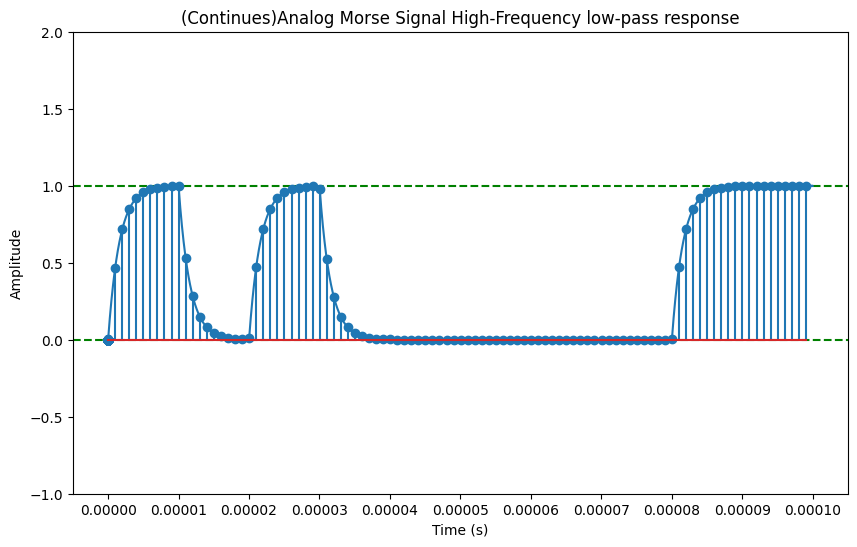

In [64]:
plt.figure(figsize=(10, 6))
plt.axhline(y=0, color='g', linestyle='--')
plt.axhline(y=1, color='g', linestyle='--')
plt.title("(Continues)Analog Morse Signal High-Frequency low-pass response")
plt.plot(T_CONT_H, after_copper_wire)
plt.stem(Ex_T_DIS_Morse_H,Ex_DIS_Morse_Signal_Raw_H)
plt.xticks(np.linspace(0, 0.0001, 11))
plt.ylim(-1,2)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

#### Repeat the simulation and raise the COM Frequency 

Raise the COM-Frequency (Ex_MORSE_COM_FREQ_H) higher step by step.
e.g. 


3*100000 


4*100000


5*100000


...


And plot out the data to see the effects of the low-pass wire on limiting our data transfer rate.

In [65]:
# Morse communication Frequency in [Hz]
# Before (100000)
# default (2*100000)
Ex_MORSE_COM_FREQ_H = 6*100000

# Generate the Morse Signal in continues-time (CONT)
Ex_CONT_Morse_Signal_Send_H = code_to_signal(T_CONT_H, encrypt(Ex_MESSAGE_H.upper()), Ex_MORSE_COM_FREQ_H)

# Apply the copper wire as a low-pass filter with cutoff frequency in [Hz]
# default(100000)
CUTOFF_FREQ_H = 100000
after_copper_wire = butter_lowpass_filter_H(Ex_CONT_Morse_Signal_Send_H,CUTOFF_FREQ_H,T_CONT_FREQ_H,1)


# Sampled by ADC
# Generate Time Data
Ex_T_DIS_Morse_H = analog_digital_converter(T_CONT_H,
                                          after_copper_wire,
                                          Ex_SAMPLING_FREQ_H,
                                          "t")
# Sample the Signal
Ex_DIS_Morse_Signal_Raw_H = analog_digital_converter(T_CONT_H,
                                                   after_copper_wire,
                                                   Ex_SAMPLING_FREQ_H,
                                                   "s")


##### Your code here (Exercise)

And plot out the resulting signal (after_copper_wire) nicely and overlay the sampled signal(Ex_DIS_Morse_Signal_Raw_H) on top of the analog signal.

Pay attention to the array size. The analog signal data has a greater size compared with the sampled(discrete) signal.

If you have difficulties doing so, you may have a look at the solution.

In [66]:
# Your code here---------------------------------------------------------------------------------



# Your code here---------------------------------------------------------------------------------

###### Solution

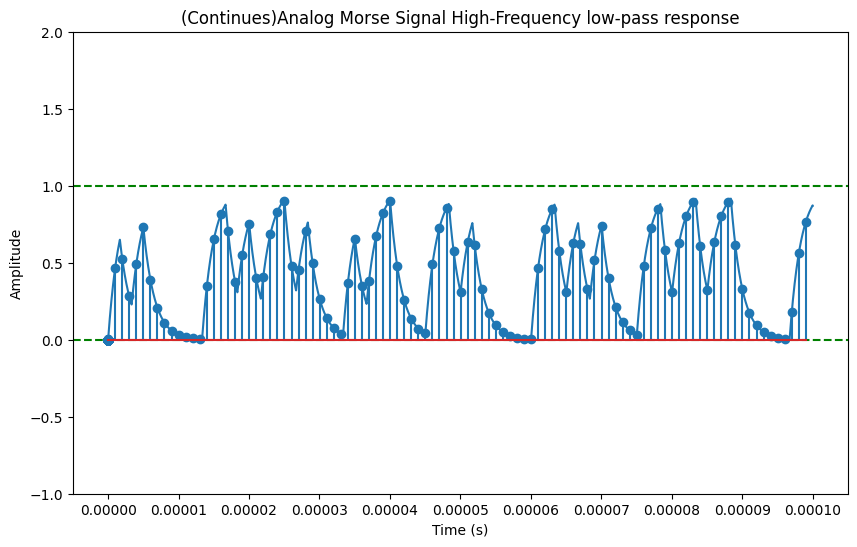

In [67]:
plt.figure(figsize=(10, 6))
plt.axhline(y=0, color='g', linestyle='--')
plt.axhline(y=1, color='g', linestyle='--')
plt.title("(Continues)Analog Morse Signal High-Frequency low-pass response")
plt.plot(T_CONT_H, after_copper_wire)
plt.stem(Ex_T_DIS_Morse_H,Ex_DIS_Morse_Signal_Raw_H)
plt.xticks(np.linspace(0, 0.0001, 11))
plt.ylim(-1,2)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

#### Conclusion

When a signal passes through a copper wire used as a signal cable, its impedance starts to have effects on damping the signal when we use a high-frequency signal to transfer our data.

The longer the cable, the higher the impedance, and the stronger the damping effects on our signal. The transition between the state "ON" and "OFF" (1 and 0) becomes smoother, hence increasing the difficulty when we trying to normalize the signal and determine when it is an "ON" and when it is an "OFF".

At some point, it's impossible to identify the "ON" and "OFF" anymore. In comparison, a fiber optic has significantly lower damping effects on the light signals across longer distances. That also partially explains why with fiber optic we have a higher bandwidth and higher internet speed compared with coaxial cable internet.


Higher COM-Frequency requires in general better electronics equipment that can run on high frequency, which also sets a limit on our maximum operating frequency.